# Análisis de datos para la creación del modelo predictivo de diagnóstico de enfermedades cardiovasculares

Pimero iniciaremos la exploración de este [conjunto de datos](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset) proporcionado por el usuario de [Kaggle](https://www.kaggle.com/) [sulianova](https://www.kaggle.com/sulianova). Este conjunto de datos consiste en un total de 70,000 registros de pacientes, presentando 11 características y una característica objetivo. Todos los registros fueron recolectados durante exámenes médicos.

## Descripción de los datos

Hay 3 tipos diferentes de características de entrada:
* Objetiva: información objetiva.
* Revisión: resultados de una revisión médica.
* Subjetiva: información dada por el paciente.

### Características:
|Característica|Tipo de Característica|Nombre en el Dataset|Unidad|
|:-------------|:---------------------|:-------------------|:----:|
|Edad  | Objetiva | age    | int (días)|
|Peso  | Objetiva | height | int (cm) |
|Talla | Objetiva | weight | float (kg) |
|Sexo  | Objetiva | gender | 1: mujer, 2: hombre |
|Presión Arterial Sistólica | Revisión | ap_hi | int (mmHg)|
|Presión Arterial Diastólica| Revisión | ap_lo | int (mmHg)|
|Colesterol | Revisión | cholesterol | 1: normal, 2: arriba de lo normal, 3: muy arriba de lo normal |
|Glucosa    | Revisión | gluc | 1: normal, 2: arriba de lo normal, 3: muy arriba de lo normal |
|Fumador | Subjetiva | smoke | binario |
|Consumo de Alcohol | Subjetiva | alco | binario |
|Actividad Física | Subjetiva | active | binario |
|Presencia o ausencia de una Enfermedad Cardiovacular | Variable objetivo | cardio | binario |

In [1]:
# importando librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

# importando el dataset
# en este caso el carácter que delimita es ';' y no ','
data = pd.read_csv("cardio_train.csv", delimiter = ';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [2]:
# Para este proyecto el campo id no nos interesa
data.drop(['id'], axis=1, inplace=True)
# inplace sobreescribe el df, evita asignar df = df.drop()

# La edad esta dada en días, la transformaremos a años para un mejor entendimiento
data['age'] = data['age']/365

# De igual manera nos es mas facíl ver la talla como metros en vez de cm
data['height'] = data['height']/100

# Mas delante vamos a comprobar el impacto que tiene para el entrenamiento quitar los campos de peso y talla
# y en su lugar solo tomar en cuenta el índice de masa corporal (IMC=peso(kg)/(talla(m))^2)
data['imc'] = data['weight'] / data['height']**2

data.head().round(2)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imc
0,50.39,2,1.68,62.0,110,80,1,1,0,0,1,0,21.97
1,55.42,1,1.56,85.0,140,90,3,1,0,0,1,1,34.93
2,51.66,1,1.65,64.0,130,70,3,1,0,0,0,1,23.51
3,48.28,2,1.69,82.0,150,100,1,1,0,0,1,1,28.71
4,47.87,1,1.56,56.0,100,60,1,1,0,0,0,0,23.01


In [3]:
# Identificando la presencia de valores nulos
data.isna().sum()
# En este caso, no hay

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
imc            0
dtype: int64

In [4]:
# Identificando filas duplicadas
duplicados = len(data) - len(data.drop_duplicates())  # Solo para ver cuantas filas estan duplicadas
print("filas duplicadas = {0}".format(duplicados)) 

# En este caso no hace falta eliminar filas duplicadas, debido a la naturaleza de los datos
# data.drop_duplicates(inplace=True)
# print("{0} campos duplicados borrados, nuevas dimensiones del dataset = {1}".format(duplicados,data.shape))

filas duplicadas = 24


In [5]:
# Ahora con los datos un poco más legibles podemos ver un resumen rápido de las características
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,70000.0,53.34,6.76,29.58,48.39,53.98,58.43,64.97
gender,70000.0,1.35,0.48,1.00,1.00,1.00,2.00,2.00
height,70000.0,1.64,0.08,0.55,1.59,1.65,1.70,2.50
weight,70000.0,74.21,14.40,10.00,65.00,72.00,82.00,200.00
ap_hi,70000.0,128.82,154.01,-150.00,120.00,120.00,140.00,16020.00
ap_lo,70000.0,96.63,188.47,-70.00,80.00,80.00,90.00,11000.00
cholesterol,70000.0,1.37,0.68,1.00,1.00,1.00,2.00,3.00
gluc,70000.0,1.23,0.57,1.00,1.00,1.00,1.00,3.00
smoke,70000.0,0.09,0.28,0.00,0.00,0.00,0.00,1.00
alco,70000.0,0.05,0.23,0.00,0.00,0.00,0.00,1.00


De este resumen notamos que 
1. La distribución de personas enfermas con sanas es bastante balanceada.
2. Parace haber bastantes variables objetivas con valores atípicos, pacticularmente talla, peso, ap_hi y ap_lo. Habrá que revisar y limpiar estos datos.

Primero vamos a analizar las relaciones entre peso, talla e imc.

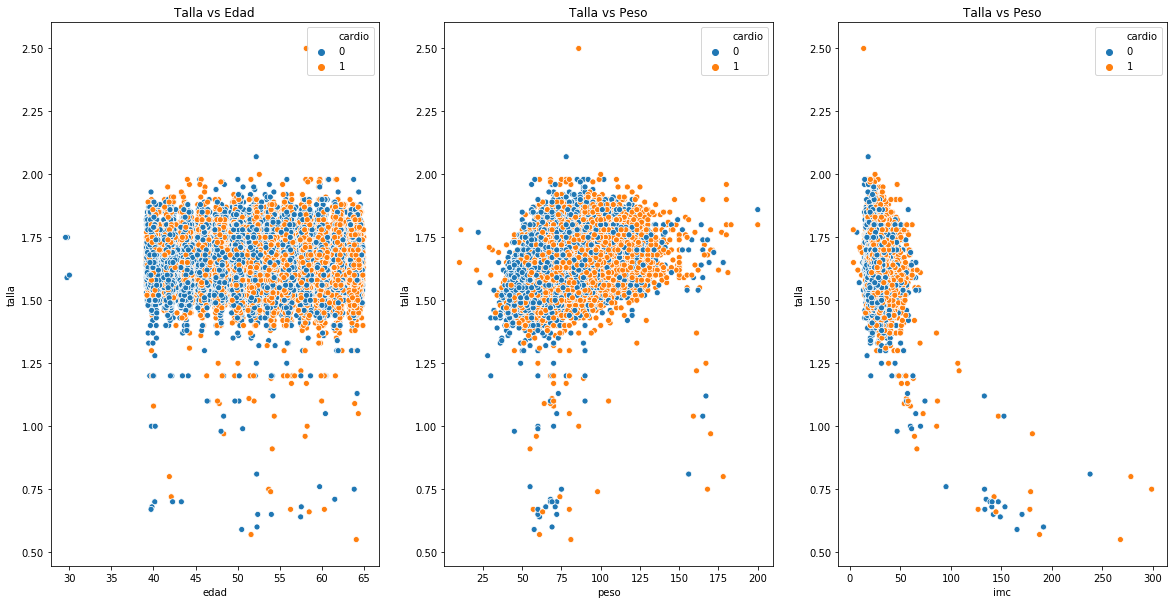

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))

sns.scatterplot(data['age'],data['height'],hue=data['cardio'],ax=ax1)
ax1.set(xlabel='edad', ylabel='talla')
ax1.set_title('Talla vs Edad')

sns.scatterplot(data['weight'],data['height'],hue=data['cardio'],ax=ax2)
ax2.set(xlabel='peso', ylabel='talla')
ax2.set_title('Talla vs Peso')

sns.scatterplot(data['imc'],data['height'],hue=data['cardio'],ax=ax3)
ax3.set(xlabel='imc', ylabel='talla')
ax3.set_title('Talla vs Peso')

plt.show()

1. Podemos notar que no existen niños en nuestro dataset, lo que hace que la aparición de personas con menos de 1.20m de altura sea muy raro (La estatura adulta promedio entre las personas con enanismo es de 1.22m). También vemos que hay una sola persona que mide 2.5m, asi que, tomaremos esto también como una variable atípica (El jugador más alto que jamás ha pisado una cancha de la NBA media 2.31m).
2. En la otra gráfica existen personas que miden menos de un metro de altura pero pesan mas de 175Kg, esto parece no ser muy real. Si nos basamos en la siguiente tabla de imc <img src="imc-rangos.webp" width="30%"> tenemos que valores arriba de 50 son muy poco comunes y valores arriba de 70 se antojan casi imposibles. De manera similar, valores de imc debajo de 16 (por la naturaleza de este proyecto) los omitiremos.

In [7]:
print(f'Dimensiones del dataset: {data.shape}')

# limpiando datos
# si la altura es menor a 1.22m o mayor a 2.3m borramos la fila
filtro1 =(data['height']<1.22) | (data['height']>2.3)
data.drop(index = list(data[filtro1].index),inplace=True)
print(f'Nuevas dimensiones del dataset: {data.shape}')

# si el imc es menor a 10 o mayor a 70 borramos la fila
filtro2 =(data['imc']<10) | (data['imc']>70)
data.drop(index = list(data[filtro2].index),inplace=True)
print(f'Nuevas dimensiones del dataset: {data.shape}')

Dimensiones del dataset: (70000, 13)
Nuevas dimensiones del dataset: (69913, 13)
Nuevas dimensiones del dataset: (69904, 13)


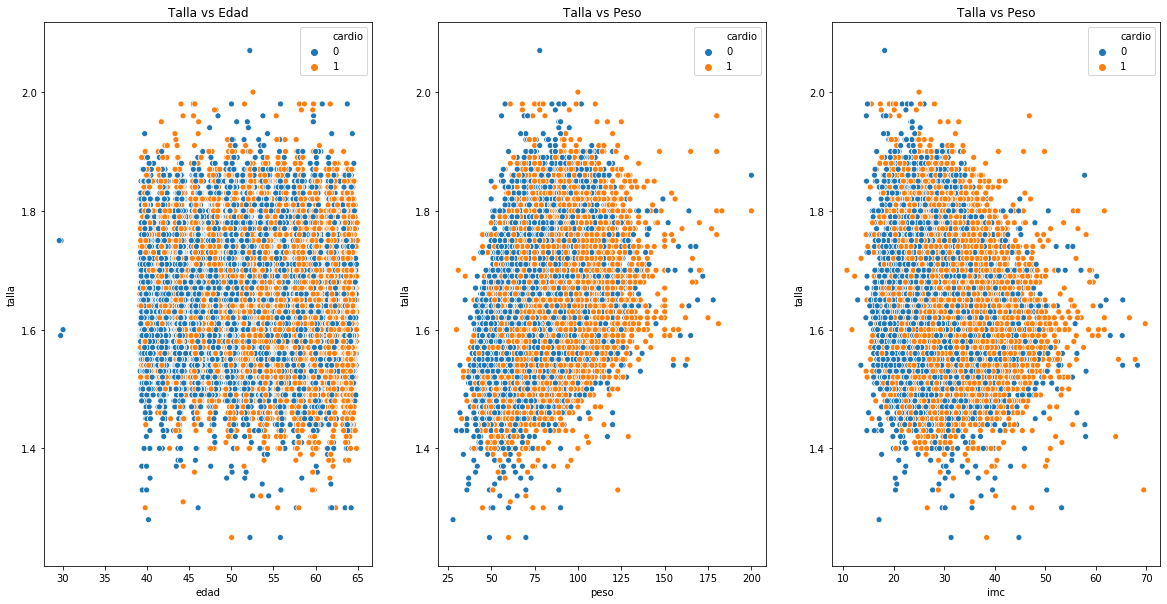

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))

sns.scatterplot(data['age'],data['height'],hue=data['cardio'],ax=ax1)
ax1.set(xlabel='edad', ylabel='talla')
ax1.set_title('Talla vs Edad')

sns.scatterplot(data['weight'],data['height'],hue=data['cardio'],ax=ax2)
ax2.set(xlabel='peso', ylabel='talla')
ax2.set_title('Talla vs Peso')

sns.scatterplot(data['imc'],data['height'],hue=data['cardio'],ax=ax3)
ax3.set(xlabel='imc', ylabel='talla')
ax3.set_title('Talla vs Peso')

plt.show()

Ahora los valores de peso y talla parecen dar un poco mas de sentido.
Lo siguiente será analizar los datos de presión arterial.

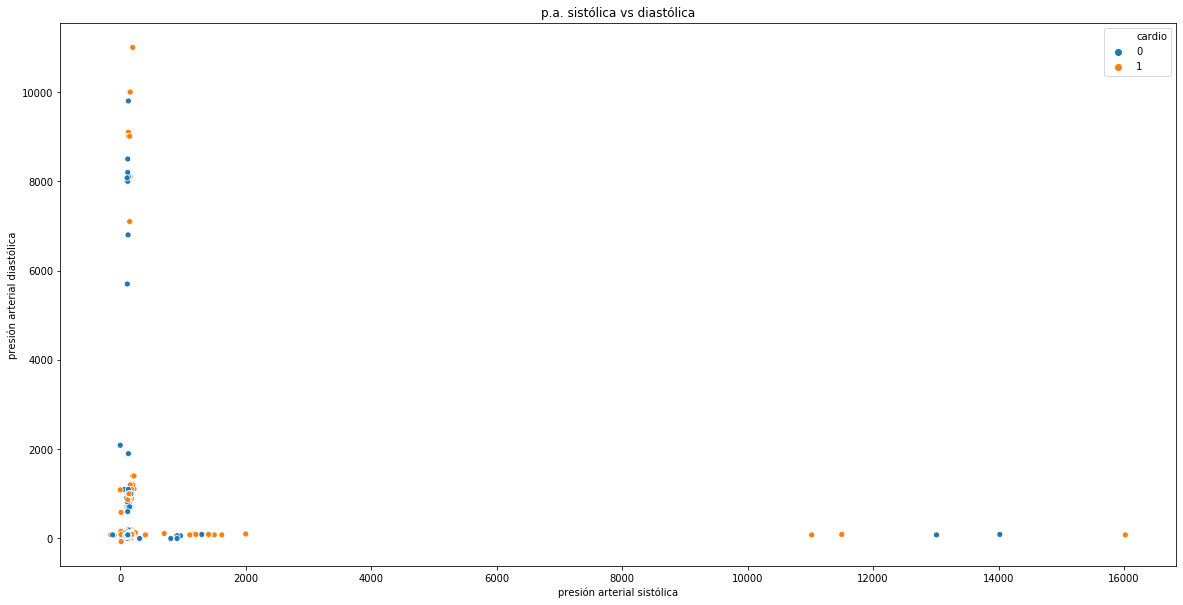

In [9]:
fig, ax1 = plt.subplots(1,1, figsize=(20,10))

sns.scatterplot(data['ap_hi'],data['ap_lo'],hue=data['cardio'],ax=ax1)
ax1.set(xlabel='presión arterial sistólica', ylabel='presión arterial diastólica')
ax1.set_title('p.a. sistólica vs diastólica')

plt.show()

* Aquí claremente podemos notar que existen variables con valores irreales. Tomando como base la siguiente tabla de presión arterial <img src="rangos-presion-arterial.png" width="40%"> se tiene que la presión sistólica a lo más puede estar en un rango (dando un poco del holgura) de 50 mmHg a 200 mmHg, mientras que la presión diastólica se encuentra en un rango de 40 mmHg a 150 mmHg.

In [10]:
print(f'Dimensiones del dataset: {data.shape}')

# limpiando datos
# si la p.s. es menor a 50mmHg o mayor a 200mmHg borramos la fila
filtro3 =(data['ap_hi']<50) | (data['ap_hi']>200)
data.drop(index = list(data[filtro3].index),inplace=True)
print(f'Nuevas dimensiones del dataset: {data.shape}')

# si la p.d. es menor a 40mmHg o mayor a 150mmHg borramos la fila
filtro4 =(data['ap_lo']<40) | (data['ap_lo']>150)
data.drop(index = list(data[filtro4].index),inplace=True)
print(f'Nuevas dimensiones del dataset: {data.shape}')

Dimensiones del dataset: (69904, 13)
Nuevas dimensiones del dataset: (69618, 13)
Nuevas dimensiones del dataset: (68613, 13)


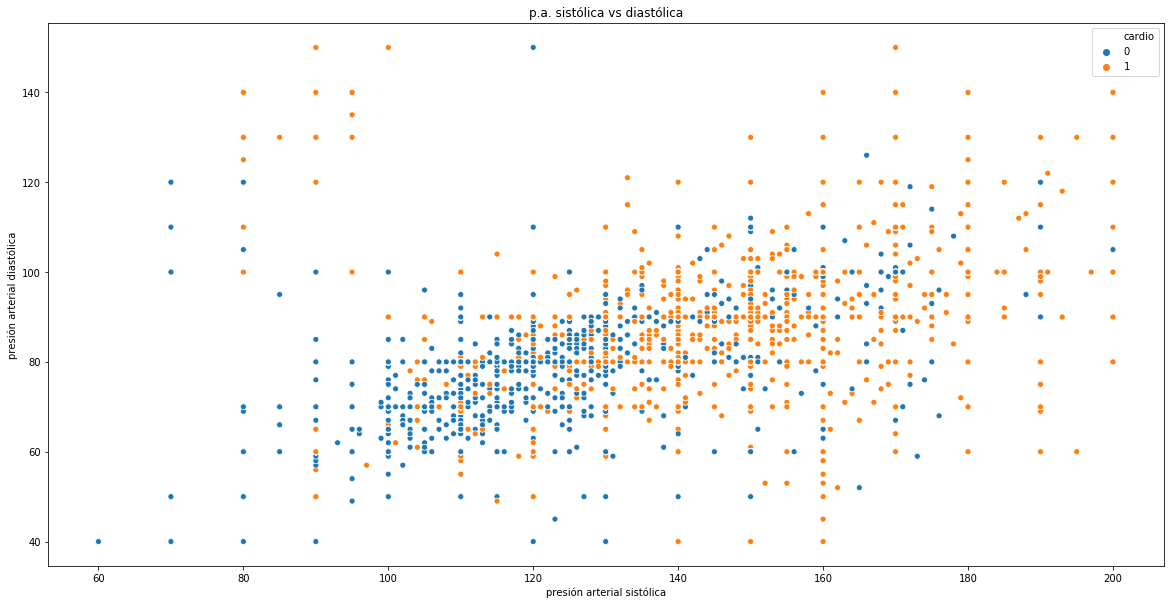

In [11]:
fig, ax1 = plt.subplots(1,1, figsize=(20,10))

sns.scatterplot(data['ap_hi'],data['ap_lo'],hue=data['cardio'],ax=ax1)
ax1.set(xlabel='presión arterial sistólica', ylabel='presión arterial diastólica')
ax1.set_title('p.a. sistólica vs diastólica')

plt.show()

Ahora tenemos presiones alteriales mas reales.

## Buscando relaciones

In [22]:
mujeres = len(data['gender'][data['gender']==1])
hombres = len(data['gender'][data['gender']==2])
total = mujeres + hombres
print("mujeres={0}({1:.2f}%), hombres={2}({3:.2f}%), total={4}"
      .format(mujeres,mujeres/total*100,hombres,hombres/total*100,total))

mujeres=44694(65.14%), hombres=23919(34.86%), total=68613


In [80]:
filtro = (data['cardio']==1)
pTot  = len(data['cardio'][filtro])
pMuj = len(data['cardio'][(data['gender']==1)&filtro])
pHom = len(data['cardio'][(data['gender']==2)&filtro])
print("Personas enfermas por sexo")
print("mujeres={0}({1:.2f}%), hombres={2}({3:.2f}%), total={4}({5:.2f}%)"
      .format(pMuj,pMuj/mujeres*100,
              pHom,pHom/hombres*100,
              pTot,pTot/total*100))

Personas enfermas por sexo
mujeres=21990(49.20%), hombres=11944(49.94%), total=33934(49.46%)


In [78]:
filtro = (data['imc']>24.9)
pTot = len(data['cardio'][filtro])
pEnf = len(data['cardio'][filtro&(data['cardio']==1)])
pSan = len(data['cardio'][filtro&(data['cardio']==0)])
print("Personas con IMC alto")
print("personas enfermas={0}({1:.2f}%), personas sanas={2}({3:.2f}%), total={4}({5:.2f}%)"
      .format(pEnf,pEnf/pTot*100,
              pSan,pSan/pTot*100,
              pTot,pTot/total*100))

Personas con IMC alto
personas enfermas=24110(55.35%), personas sanas=19451(44.65%), total=43561(63.49%)


In [74]:
filtro = (data['ap_hi']>120)|(data['ap_lo']>80)
pTot = len(data['cardio'][filtro])
pEnf = len(data['cardio'][filtro&(data['cardio']==1)])
pSan = len(data['cardio'][filtro&(data['cardio']==0)])
print("Personas con presion arterial alta")
print("personas enfermas={0}({1:.2f}%), personas sanas={2}({3:.2f}%), total={4}({5:.2f}%)"
      .format(pEnf,pEnf/pTot*100,
              pSan,pSan/pTot*100,
              pTot,pTot/total*100))

Personas con presion arterial alta
personas enfermas=21767(73.10%), personas sanas=8010(26.90%), total=29777(43.40%)


In [73]:
filtro = (data['ap_hi']>120)|(data['ap_lo']>80)&(data['imc']>24.9)
pTot = len(data['cardio'][filtro])
pEnf = len(data['cardio'][filtro&(data['cardio']==1)])
pSan = len(data['cardio'][filtro&(data['cardio']==0)])
print("Personas con imc alto y presion arterial alta")
print("personas enfermas={0}({1:.2f}%), personas sanas={2}({3:.2f}%), total={4}({5:.2f}%)"
      .format(pEnf,pEnf/pTot*100,
              pSan,pSan/pTot*100,
              pTot,pTot/total*100))

Personas con imc alto y presion arterial alta
personas enfermas=21557(73.81%), personas sanas=7651(26.19%), total=29208(42.57%)
